# Import libraries

In [109]:
import spacy
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
from deep_translator import GoogleTranslator
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Setting NLTK resources

In [110]:
# Define the NLTK data path
NLTK_DATA_PATH = os.path.expanduser("~/nltk_data")  # Change this path if needed

# Ensure the NLTK data directory exists
os.makedirs(NLTK_DATA_PATH, exist_ok=True)

# Function to check if a resource exists and download if missing
def download_nltk_resource(resource, subfolder="corpora"):
    resource_path = os.path.join(NLTK_DATA_PATH, subfolder, resource)
    if not os.path.exists(resource_path):
        print(f"Downloading {resource}...")
        nltk.download(resource, download_dir=NLTK_DATA_PATH)
    else:
        print(f"{resource} already exists, skipping download.")

# Check and download required NLTK resources
download_nltk_resource("stopwords.zip")
download_nltk_resource("punkt.zip", "tokenizers")
download_nltk_resource("vader_lexicon.zip", "sentiment")

# Set NLTK's data path
nltk.data.path.append(NLTK_DATA_PATH)

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

stopwords.zip already exists, skipping download.
punkt.zip already exists, skipping download.
vader_lexicon.zip already exists, skipping download.


# Load the vectorizer and model

In [111]:
import pickle
# Load the vectorizer and model
with open("../models/tfidf_vectorizer_AE.pkl", "rb") as f:
    tfidf_vectorizer_AE = pickle.load(f)

with open("../models/SVM_opinion_category_classifier.pkl", "rb") as f:
    SVM_opinion_category_classifier = pickle.load(f)

with open("../models/tfidf_vectorizer_SA.pkl", "rb") as f:
    tfidf_vectorizer_SA = pickle.load(f)

with open("../models/svm_sentiment_classifier.pkl", "rb") as f:
    svm_sentiment_classifier = pickle.load(f)

In [112]:
# Set the option to display full column width and all rows
pd.set_option("display.max_colwidth",None)
pd.set_option("display.max_rows",None)

## Translate text into English

In [113]:
def translate(text):
    translator = GoogleTranslator(source='auto', target='en')
    return translator.translate(text)

text1 = "बढ़िया खाना था"
print(translate(text1))

the food was great


## Handling Emojies

In [114]:
positive_emojis = """😄😀😁😆😂🤣😊🙂😎😉😍🥰😘😋😛😝😜🤪🤩🥳🥰❤️👍👌🤟🍔🍕🍣🍰🍹🍷🍺
                    🍦🍯🥞🍟🍩🥼🎉🎊🥳🍚🍘🍥🥠🥮🍢🍡🍧🍨🍦🥧🧁🍰🎂🍮🍭🍬🍫🍿🍩🍪🌰🥜
                    🍯🍻🥂🍷🍾😀😃😄😆😅🥲\😊😇🙂😀😃😄😁😅😆😂🙂😊🤒👏"""

    
negative_emojis = """😔😞😢😭😤😠😡🤬😩😫🥺😖😣😠😤😷🤒🤕😐😶😒😏🙁🥶😨😱😰😳🥵😳😵
                     🤯🤐🤮🥴🤢👎😈👿💔😩😔😞😢😭"""


# add space between word and emoji
def handle_emoji_helper(text):
    i = 0
    lst = list(text)
    for word in text:
        if word !=" " and (word in positive_emojis or word in negative_emojis):
            lst.insert(i," ")
        i+=1
    return "".join(lst)

def handle_emoji(sentence):
    sentence = handle_emoji_helper(sentence)
    words = sentence.split()
    converted_sentence = []
    for word in words:
        if word in positive_emojis:
            converted_sentence.append("good") # Don't change ( one word sentences will be removed in
        elif word in negative_emojis:                                     #      preprocessing )
            converted_sentence.append("bad")
        else:
            converted_sentence.append(word)
    return " ".join(converted_sentence)

# # Example usage:
# input_sentence = "😀"
# input_sentence = "बढ़िया खाना था😀"
# converted = handle_emoji(input_sentence)
# print(converted)

# Data PreProcessing

In [115]:
# Data Cleaning
def clean_text(text):
    if text is not None:
        text = text.lower() # Lowercase the text
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)   # Remove special characters and punctuation
    return text

# Text preprocessing functions
def preprocess_text(text, state = 0):
    text = handle_emoji(text)
    if state == 1:
        text = translate(text)
        text = clean_text(text)
    if text is not None:
        if state == 0:
            text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if (word.lower() not in stop_words or word.lower() == 'not') and len(word)>2])
            text = text if len(text.split()) > 1 else ""    
        
    return text

### Function to tokenize text into sentences

In [116]:
def split_complex_sentence(text):
    doc = nlp(text) # Parse the text
    simpler_sentences = []
    temp_sentence = []
    
    # Iterate through the parsed tokens
    for token in doc:
        # Check for coordinating conjunctions (e.g., "and," "but") to split the sentence
        if token.dep_ == "cc":
            if temp_sentence:
                simpler_sentences.append(" ".join(temp_sentence))
            temp_sentence = []
        else:
            temp_sentence.append(token.text)

    if temp_sentence:
        simpler_sentences.append(" ".join(temp_sentence))
    
    sentences = []
    for sentence in simpler_sentences:
        sentences.append(sent_tokenize(sentence))

    flattened_sentences = [sentence for sublist in sentences for sentence in sublist]
    return flattened_sentences

# text  = The service at the restaurant was excellent. The food was also good but atmosphere were not good."
# simplified_sentences = split_complex_sentence(text)
# for sentence in simplified_sentences:
#     print(sentence)


# Load Unlabeled dataset [ Define filename if you are running this file directly ]

In [117]:
input_df = pd.read_csv("../datasets/testing_dataset/First_Restaurant_Review_dataset.csv")

In [118]:
input_df.head()

,Wow... Loved this place.
0,Crust is not good.
1,Not tasty and the texture was just nasty.
2,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
3,The selection on the menu was great and so were the prices.
4,Now I am getting angry and I want my damn pho.


### Add index to the DataFrame

In [119]:
input_df['idx'] = range(10, (len(input_df) + 1)*10, 10)
input_df.columns = ['Review', 'idx']
input_df.head()

,Review,idx
0,Crust is not good.,10
1,Not tasty and the texture was just nasty.,20
2,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,30
3,The selection on the menu was great and so were the prices.,40
4,Now I am getting angry and I want my damn pho.,50


### Converting every Review text into simple sentences and forming new dataframe as discussed earlier

In [120]:
new_df_list = []  # Create a list to store DataFrames

for i, (idx, text) in enumerate(zip(input_df['idx'], input_df['Review'])):
    sentences = split_complex_sentence(text)  # split_complex_sentence defined in the start
    sentences_df = pd.DataFrame({'Review': sentences, 'idx': range(idx, idx + len(sentences))})
    new_df_list.append(sentences_df)

new_df = pd.concat(new_df_list, ignore_index=True)  # Concatenate all DataFrames at once


### Replacing old dataset by new dataset

In [121]:
input_df = new_df.copy()
input_df.head() # print dataset head


,Review,idx
0,Crust is not good .,10
1,Not tasty,20
2,the texture was just nasty .,21
3,Stopped by during the late May bank holiday off Rick Steve recommendation,30
4,loved it .,31


### Preprocessing Review to create new column cleaned_review

In [122]:
from tqdm import tqdm
nltk.download('wordnet')
tqdm.pandas()

# df_temp['y'] = df_temp.ratings.progress_map(label)
input_df['Cleaned_Review'] = input_df['Review'].progress_map(preprocess_text)
input_df.head()

[nltk_data] Downloading package wordnet to /home/apoorv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 1578/1578 [00:00<00:00, 36841.91it/s]


,Review,idx,Cleaned_Review
0,Crust is not good .,10,Crust not good
1,Not tasty,20,Not tasty
2,the texture was just nasty .,21,texture nasty
3,Stopped by during the late May bank holiday off Rick Steve recommendation,30,Stopped late May bank holiday Rick Steve recommendation
4,loved it .,31,


### Deleting rows where cleaned_review column is empty

In [123]:
input_df = input_df[input_df['Cleaned_Review'] != ""]
# input_df

### Drop the custom index and reset to the default integer-based index

In [124]:
input_df.reset_index(drop=True, inplace=True)

### Rearrange the column order

In [125]:
# Create a list of column names in the desired order
desired_order = ['idx', 'Review', 'Cleaned_Review']

# Rearrange the columns
input_df = input_df[desired_order]

# Opinion Target (Aspect) Extraction

In [126]:
# An empty list for obtaining the extracted aspects from sentences.  
aspects =[]

sentences = input_df['Review']
sentences = sentences.astype(str)
# Performing Aspect Extraction 
for sen in sentences: 
    important = nlp(sen)  # Fix the variable name 'sen'
    descriptive_item = '' 
    target = '' 
    temp_target = ''
    for token in important: 
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN': 
            target = token.text   
        if target =='' and token.pos_ == 'NOUN': 
            temp_target = token.text 

    if target == '': target = temp_target
    aspects.append(target)

In [127]:
# creating a dataset having sinlge column = Opinion_Target
new_column_df = pd.DataFrame({'Opinion_Target' : aspects})

# Concatenate new column ( Opinion_Target ) into input_df dataset horizontally (along columns)
input_df = pd.concat([input_df, new_column_df], axis=1)
input_df.head()

,idx,Review,Cleaned_Review,Opinion_Target
0,10,Crust is not good .,Crust not good,Crust
1,20,Not tasty,Not tasty,
2,21,the texture was just nasty .,texture nasty,texture
3,30,Stopped by during the late May bank holiday off Rick Steve recommendation,Stopped late May bank holiday Rick Steve recommendation,recommendation
4,40,The selection on the menu was great,selection menu great,selection


# Predict the Opinion_Category 

In [128]:
# Vectorize the Opinion_Target using the  tfidf_vectorizer
sample_tfidf = tfidf_vectorizer_AE.transform(input_df['Opinion_Target'])

# Predicting the Opinion_Category 
predicted_aspect_category = SVM_opinion_category_classifier.predict(sample_tfidf)

# adding column Opinion_Category
input_df['Opinion_Category'] = predicted_aspect_category

# unique values of Opinion_Category 
input_df['Opinion_Category'].value_counts()

Opinion_Category
FOOD#QUALITY                1047
SERVICE#GENERAL              112
RESTAURANT#GENERAL            91
AMBIENCE#GENERAL              36
FOOD#STYLE_OPTIONS            22
RESTAURANT#MISCELLANEOUS       7
DRINKS#QUALITY                 7
LOCATION#GENERAL               2
DRINKS#STYLE_OPTIONS           1
Name: count, dtype: int64

In [129]:
input_df.head()

,idx,Review,Cleaned_Review,Opinion_Target,Opinion_Category
0,10,Crust is not good .,Crust not good,Crust,FOOD#QUALITY
1,20,Not tasty,Not tasty,,FOOD#QUALITY
2,21,the texture was just nasty .,texture nasty,texture,FOOD#QUALITY
3,30,Stopped by during the late May bank holiday off Rick Steve recommendation,Stopped late May bank holiday Rick Steve recommendation,recommendation,FOOD#QUALITY
4,40,The selection on the menu was great,selection menu great,selection,FOOD#QUALITY


### Handle missing values of Opinion_Target Column 

In [130]:
# Opinion_Target = "" and Opinion_Category = "FOOD#QUALITY" then food of before # is Opinion_Target
# Assumption just  to handle missing value
def missing_value_handler(df):
    return df['Opinion_Category'].split('#')[0].lower() if pd.isna(df['Opinion_Target']) else df['Opinion_Target']

input_df['Opinion_Target'] = input_df.apply(missing_value_handler, axis = 1)

In [131]:
# input_df

# Predict the Opinion_Polarity

In [132]:
# Vectorize the sample sentence using the same tfidf_vectorizer
sample_tfidf = tfidf_vectorizer_SA.transform(input_df['Cleaned_Review'])

# Predict the sentiment for the sample sentence
Predicted_Opinion_Polarity = svm_sentiment_classifier.predict(sample_tfidf)

# adding new column Opinion_Polarity in dataset
input_df['Opinion_Polarity'] = Predicted_Opinion_Polarity


In [133]:
# print dataset
input_df.tail()

,idx,Review,Cleaned_Review,Opinion_Target,Opinion_Category,Opinion_Polarity
1320,9970,Overall I was not impressed,Overall not impressed,,FOOD#QUALITY,negative
1321,9971,would not go back .,would not back,,FOOD#QUALITY,negative
1322,9980,"The whole experience was underwhelming ,",whole experience underwhelming,experience,FOOD#QUALITY,positive
1323,9981,I think we 'll just go to Ninja Sushi next time .,think 'll Ninja Sushi next time,time,FOOD#QUALITY,positive
1324,9990,"Then , as if I had n't wasted enough of my life there , they poured salt in the wound by drawing out the time it took to bring the check .",n't wasted enough life poured salt wound drawing time took bring check,check,FOOD#QUALITY,positive


# Charts

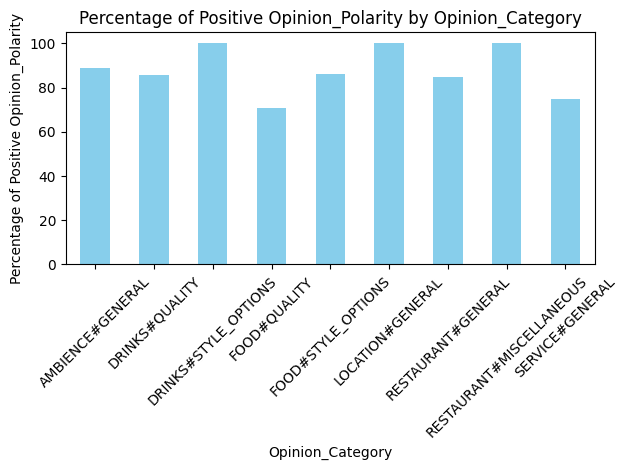

In [134]:
import matplotlib.pyplot as plt
# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive Opinion_Polarity for each Opinion_Category
grouped['Percentage of Positive Opinion_Polarity'] = (grouped['positive'] / (grouped['positive'] + grouped['negative'])) * 100

# Plot the percentage of positive Opinion_Polarity for each Opinion_Category
ax = grouped['Percentage of Positive Opinion_Polarity'].plot(kind='bar', color='skyblue')
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage of Positive Opinion_Polarity')
plt.title('Percentage of Positive Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('output/images/sample_plot.jpg')
plt.show()

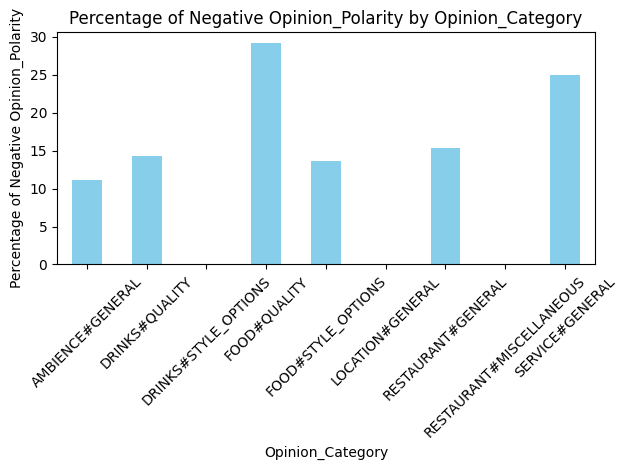

In [135]:
# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive Opinion_Polarity for each Opinion_Category
grouped['Percentage of Negative Opinion_Polarity'] = (grouped['negative'] / (grouped['positive'] + grouped['negative'])) * 100

# Plot the percentage of positive Opinion_Polarity for each Opinion_Category
ax = grouped['Percentage of Negative Opinion_Polarity'].plot(kind='bar', color='skyblue')
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage of Negative Opinion_Polarity')
plt.title('Percentage of Negative Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('output/images/sample_plot1.jpg')
plt.show()
 

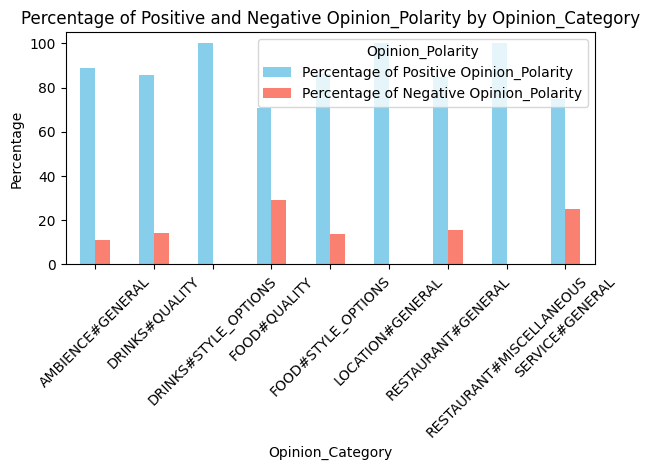

In [136]:

# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive and negative Opinion_Polarity for each Opinion_Category
grouped['Percentage of Positive Opinion_Polarity'] = (grouped['positive'] / (grouped['positive'] + grouped['negative'])) * 100
grouped['Percentage of Negative Opinion_Polarity'] = (grouped['negative'] / (grouped['positive'] + grouped['negative'])) * 100

# Plot the percentages of positive and negative Opinion_Polarity for each Opinion_Category
ax = grouped[['Percentage of Positive Opinion_Polarity', 'Percentage of Negative Opinion_Polarity']].plot(kind='bar', color=['skyblue', 'salmon'])
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage')
plt.title('Percentage of Positive and Negative Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('output/images/sample_plot2.jpg')
plt.show()

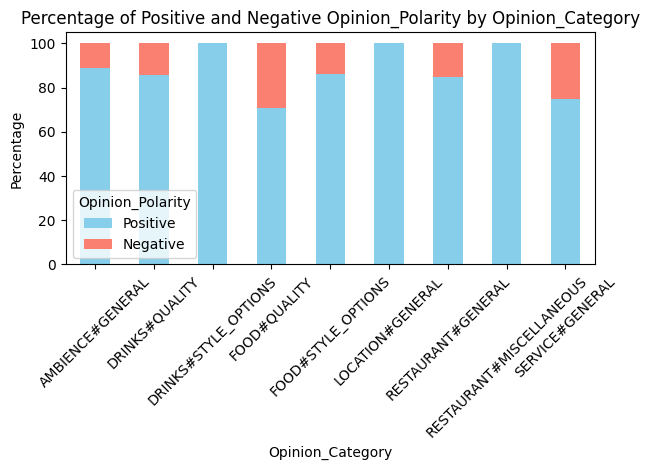

In [137]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive and negative Opinion_Polarity for each Opinion_Category
grouped['Percentage of Positive Opinion_Polarity'] = (grouped['positive'] / (grouped['positive'] + grouped['negative'])) * 100
grouped['Percentage of Negative Opinion_Polarity'] = (grouped['negative'] / (grouped['positive'] + grouped['negative'])) * 100

# Plot a stacked bar chart for the percentages
ax = grouped[['Percentage of Positive Opinion_Polarity', 'Percentage of Negative Opinion_Polarity']].plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage')
plt.title('Percentage of Positive and Negative Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend
plt.legend(title='Opinion_Polarity', labels=['Positive', 'Negative'])

# Save the chart as an image
# plt.savefig('output/images/sample_stacked_bar_chart.jpg')

# Show the chart
plt.show()


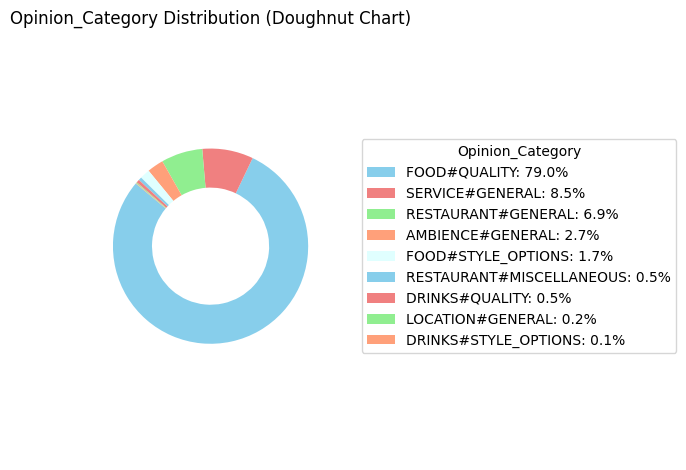

In [138]:
import matplotlib.pyplot as plt
import pandas as pd

# Group the DataFrame by 'Opinion_Category' and count occurrences
grouped = input_df['Opinion_Category'].value_counts().reset_index()
grouped.columns = ['Opinion_Category', 'Count']

# Calculate the percentage of total reviews for each category
grouped['Percentage of Total Reviews'] = (grouped['Count'] / grouped['Count'].sum()) * 100

# Set colors for the doughnut chart
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightcyan']

# Create a doughnut chart for Opinion_Category Distribution
fig, ax = plt.subplots()

# Plot the pie chart (outer circle)
wedges, texts, autotexts = ax.pie(
    grouped['Count'],
    labels=None,  # No labels on slices
    autopct='',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4)  # Set the width to create a doughnut chart
)

# Add a legend with color-coded labels and percentages in a table
legend_labels = [f'{category}: {percentage:.1f}%' for category, percentage in zip(grouped['Opinion_Category'], grouped['Percentage of Total Reviews'])]
ax.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), title="Opinion_Category")

plt.axis('equal')
plt.title('Opinion_Category Distribution (Doughnut Chart)')

plt.tight_layout()
# plt.savefig('output/images/opinion_category_doughnut_chart.jpg')
plt.show()


                          negative  positive  \
Opinion_Category                               
AMBIENCE#GENERAL                 4        32   
DRINKS#QUALITY                   1         6   
DRINKS#STYLE_OPTIONS             0         1   
FOOD#QUALITY                   305       742   
FOOD#STYLE_OPTIONS               3        19   
LOCATION#GENERAL                 0         2   
RESTAURANT#GENERAL              14        77   
RESTAURANT#MISCELLANEOUS         0         7   
SERVICE#GENERAL                 28        84   

                          Percentage of Positive Opinion_Polarity  \
Opinion_Category                                                    
AMBIENCE#GENERAL                                        88.888889   
DRINKS#QUALITY                                          85.714286   
DRINKS#STYLE_OPTIONS                                   100.000000   
FOOD#QUALITY                                            70.869150   
FOOD#STYLE_OPTIONS                                      8

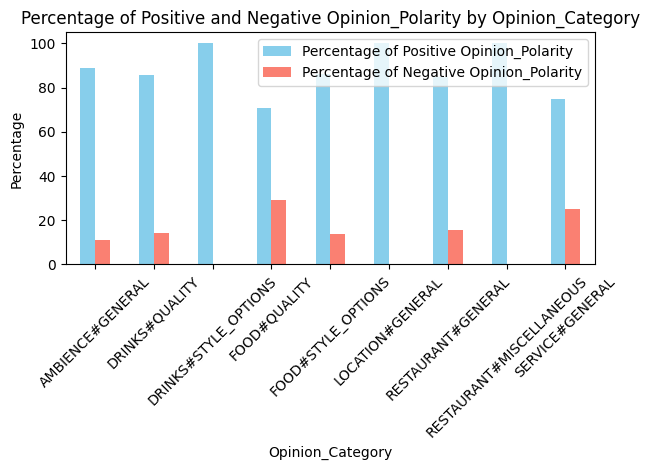

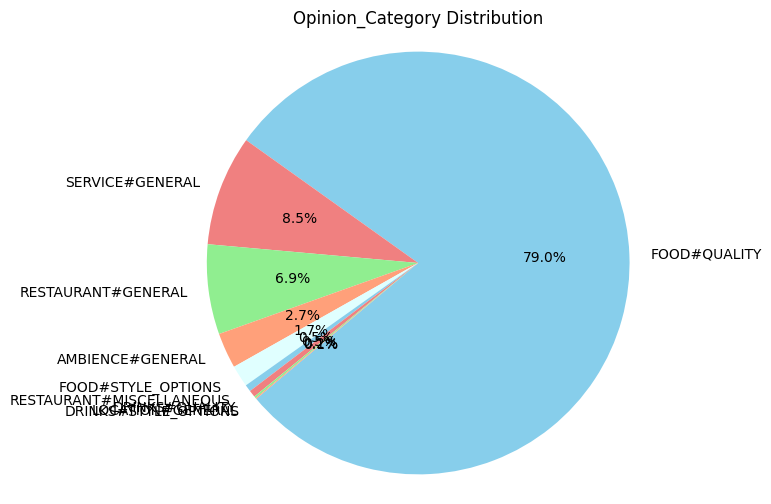

In [139]:
# Group the DataFrame by 'Opinion_Category' and 'Opinion_Polarity' and count occurrences
grouped = input_df.groupby(['Opinion_Category', 'Opinion_Polarity']).size().unstack(fill_value=0)

# Calculate the percentage of positive and negative Opinion_Polarity for each Opinion_Category
grouped['Percentage of Positive Opinion_Polarity'] = (grouped['positive'] / (grouped['positive'] + grouped['negative'])) * 100
grouped['Percentage of Negative Opinion_Polarity'] = (grouped['negative'] / (grouped['positive'] + grouped['negative'])) * 100

# Group the DataFrame by 'Aspect' and count occurrences
grouped_aspect = input_df['Opinion_Category'].value_counts().reset_index()
grouped_aspect.columns = ['Opinion_Category', 'Count']

# Calculate the percentage of each Opinion_Category in the total reviews
grouped_aspect['Percentage of Total Reviews'] = (grouped_aspect['Count'] / grouped_aspect['Count'].sum()) * 100

# Create a summary table
summary_table = grouped.join(grouped_aspect.set_index('Opinion_Category'), on='Opinion_Category')
summary_table['Percentage of Total Reviews'] = summary_table['Percentage of Total Reviews'].fillna(0)

# Print the summary table
print(summary_table)

# Plot the percentages of positive and negative Opinion_Polarity for each Opinion_Category
ax = summary_table[['Percentage of Positive Opinion_Polarity', 'Percentage of Negative Opinion_Polarity']].plot(kind='bar', color=['skyblue', 'salmon'])
ax.set_xlabel('Opinion_Category')
ax.set_ylabel('Percentage')
plt.title('Percentage of Positive and Negative Opinion_Polarity by Opinion_Category')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('static/images/sample_plot2.jpg')

# Plot the pie chart for Opinion_Category Distribution
plt.figure(figsize=(6, 6))
plt.pie(grouped_aspect['Count'], labels=grouped_aspect['Opinion_Category'], autopct='%1.1f%%', startangle=220, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightcyan'])
plt.title('Opinion_Category Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.savefig('output/images/sample_plot7.jpg')
plt.show()


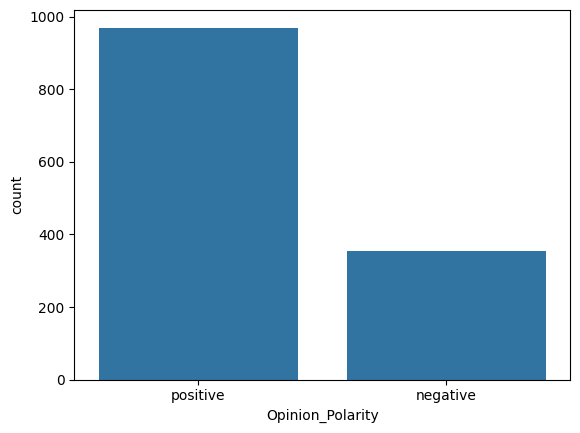

In [140]:
# Opinion_Polarity distribution in our dataset
# df.Opinion_Polarity.value_counts().sort_values().plot(kind = 'bar')
sns.countplot(x = "Opinion_Polarity", data = input_df)
plt.show()

### --------------------------------XxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxX-------------------------------------

# Aspect and Sentiment analysis for a random text

### Text

In [141]:
text = "The pizza is delicious but service is terrible. The atmosphere is also not good.😀"
text = '''I recently dined at this restaurant, and I must say the food was excellent. 
The steak was perfectly cooked and very flavorful. However, the service was unsatisfactory.
The waitstaff seemed disorganized, and our orders took longer than expected. Despite that,
the ambiance of the restaurant was lovely, and the dessert was a delightful ending to the meal. Overall, 
a mixed experience'''
# text = "बढ़िया खाना था😀"
# text = "food😀"
# text = "the food is tasty!!!"

### Breaking complex sentence into simple sentences

In [142]:
simplified_sentences = split_complex_sentence(preprocess_text(text,1))
simplified_sentences

['i recently dined at this restaurant',
 'i must say the food was excellent the steak was perfectly cooked',
 'very flavorful however the service was unsatisfactory   the waitstaff seemed disorganized',
 'our orders took longer than expected despite tha t the ambiance of the restaurant was lovely',
 'the dessert was a delightful ending to the meal overal l a mixed experience']

### Opinion Target(Aspect) Extraction

In [143]:
# An empty list for obtaining the extracted aspects from sentences.  
ext_aspects = [] 
aspects =[]

# Performing Aspect Extraction 
for sen in simplified_sentences: 
    important = nlp(sen)  # Fix the variable name 'sen'
    descriptive_item = '' 
    target = '' 
    for token in important: 
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN': 
            target = token.text
        elif token.pos_ == 'NOUN': 
            target = token.text
    if target == "": target = "restaurant"
    aspects.append(target)

print("\nASPECTS : ",aspects)


ASPECTS :  ['restaurant', 'steak', 'waitstaff', 'restaurant', 'experience']


### Predict the Opinion_Category

In [144]:
# Vectorize the sample sentence using the same tfidf_vectorizer
sample_tfidf = tfidf_vectorizer_AE.transform(aspects)

# Predict the sentiment for the sample sentence
predicted_aspect = SVM_opinion_category_classifier.predict(sample_tfidf)

print(f"Predicted Aspect Category: {predicted_aspect}")


Predicted Aspect Category: ['RESTAURANT#GENERAL' 'FOOD#QUALITY' 'SERVICE#GENERAL'
 'RESTAURANT#GENERAL' 'FOOD#QUALITY']


### Predict the Opinion_Polarity

In [145]:
# Create a SentimentIntensityAnalyzer object
sid = SentimentIntensityAnalyzer()

# Preprocess the sample sentences
preprocessed_sample_sentences = [preprocess_text(sentence,1) for sentence in simplified_sentences]

predicted_sentiments = []
# Analyze sentiment
for sentence in preprocessed_sample_sentences:
    sentiment_scores = sid.polarity_scores(sentence)
    # Determine the sentiment label
    if sentiment_scores['compound'] >= 0.05:
        sentiment_label = "positive"
    elif sentiment_scores['compound'] <= -0.05:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"

    predicted_sentiments.append(sentiment_label)
#     print(f"Text: {sentence}")
#     print(f"Compound Score: {sentiment_scores['compound']}")
print(f"Predicted Sentiment: {predicted_sentiments}")


Predicted Sentiment: ['neutral', 'positive', 'negative', 'positive', 'positive']


### Resultant Table: 

In [146]:
Result_df = pd.DataFrame({"Aspect_Term" : aspects,
                          "Aspect_Category" : predicted_aspect,
                          "Sentiment" : predicted_sentiments})
Result_df

,Aspect_Term,Aspect_Category,Sentiment
0,restaurant,RESTAURANT#GENERAL,neutral
1,steak,FOOD#QUALITY,positive
2,waitstaff,SERVICE#GENERAL,negative
3,restaurant,RESTAURANT#GENERAL,positive
4,experience,FOOD#QUALITY,positive
